In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import datetime as dt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, learning_curve 
from sklearn.metrics import recall_score,cohen_kappa_score,roc_curve, auc,accuracy_score,confusion_matrix,f1_score,precision_score,roc_auc_score,roc_curve
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import lightgbm as lgb

Train = pd.read_csv("exoTrain.csv",sep=',')
Test = pd.read_csv("exoTest.csv",sep=',')

print(Train.shape)
print(Test.shape)

(5087, 3198)
(570, 3198)


In [2]:
X_train = Train.drop('LABEL', axis=1).values
X_test = Test.drop('LABEL', axis=1).values
y_train = Train['LABEL'].values
y_test = Test['LABEL'].values



In [3]:
# Use Sklearn to create Model and train model 

print('Start training...')
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=20,learning_rate=0.05,n_estimators=20)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)


Start training...
[1]	valid_0's l1: 0.0158363	valid_0's l2: 0.00864816
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.0158545	valid_0's l2: 0.00862168
[3]	valid_0's l1: 0.0158311	valid_0's l2: 0.00858273
[4]	valid_0's l1: 0.0158646	valid_0's l2: 0.00856454
[5]	valid_0's l1: 0.0158782	valid_0's l2: 0.0085459
[6]	valid_0's l1: 0.0159822	valid_0's l2: 0.00848153
[7]	valid_0's l1: 0.0159661	valid_0's l2: 0.00843816
[8]	valid_0's l1: 0.0159181	valid_0's l2: 0.0084078
Early stopping, best iteration is:
[3]	valid_0's l1: 0.0158311	valid_0's l2: 0.00858273


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20, n_jobs=-1, num_leaves=20, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [4]:
print('Start predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Start predicting...
The rmse of prediction is: 0.0926430399628523


In [5]:


gbmModel = lgb.LGBMClassifier()
gbmModel.fit(X_train,y_train)
y_pred = gbmModel.predict(X_test)
print("Accuracy Score:",metrics.accuracy_score(y_test,y_pred))
print("ROC AUC:",metrics.roc_auc_score(y_test,y_pred))

Accuracy Score: 0.9912280701754386
ROC AUC: 0.5


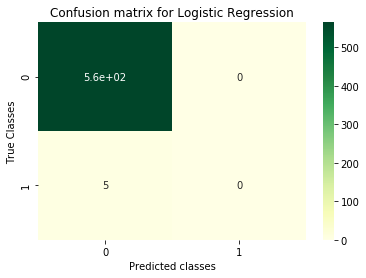

In [6]:
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [23]:
# Use LGB.train()
# Convert the training data into LightGBM dataset formate 
# manually build python dictionary with lgb parameters 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
 'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'regression', 
 'metric': {'l2', 'auc'}, 
 'num_leaves': 31, 
 'learning_rate': 0.05, 
 'feature_fraction': 0.9, 
 'bagging_fraction': 0.8, 
 'bagging_freq': 5,
 'verbose': 1 
}

print('Start training...')

gbm = lgb.train(params,lgb_train,num_boost_round=50,valid_sets=lgb_eval,early_stopping_rounds=5)


Start training...
[1]	valid_0's l2: 0.00864193	valid_0's auc: 1
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.00859433	valid_0's auc: 1
[3]	valid_0's l2: 0.00855363	valid_0's auc: 1
[4]	valid_0's l2: 0.00851146	valid_0's auc: 1
[5]	valid_0's l2: 0.00847676	valid_0's auc: 1
[6]	valid_0's l2: 0.00839803	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l2: 0.00864193	valid_0's auc: 1


In [19]:
yy_pred = gbm.predict(X_test)

accuracy=accuracy_score(yy_pred.round(),y_test)

print('The rmse of prediction is:', mean_squared_error(y_test, yy_pred) ** 0.5)

print("Accuracy Score:",accuracy)
print("ROC AUC:",metrics.roc_auc_score(y_test,y_pred2))

The rmse of prediction is: 0.09296198661633567
Accuracy Score: 0.9912280701754386
ROC AUC: 0.08318584070796459


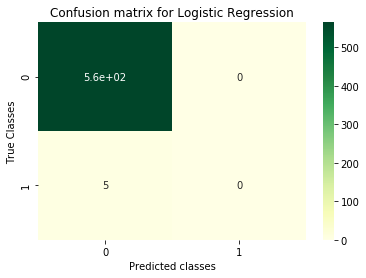

In [20]:

plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, yy_pred.round()), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()


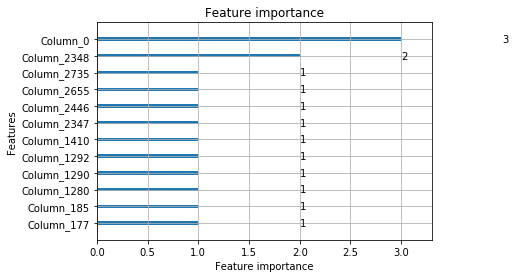

In [21]:
lgb.plot_importance(gbm)
plt.show()

In [22]:
data_train = lgb.Dataset(X_train, y_train)
cv_results = lgb.cv(params, data_train, num_boost_round=50, nfold=5, stratified=False, shuffle=True, metrics='auc',early_stopping_rounds=50,seed=0)
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

best n_estimators: 1
best cv score: 1.0


best n_estimators: 1
best cv score: 1.0
